In [3]:
from mnist import MNIST
from scipy.stats import norm, bernoulli
import numpy as np
import pandas as pd
import math
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
%matplotlib inline

## Read train and test data

In [5]:
# http://yann.lecun.com/exdb/mnist/

mndata = MNIST('data/mnist_data_files')
mndata.gz=True
train_images, train_labels = mndata.load_training()

### process data and threashold

In [6]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [7]:
train_images = (pd.DataFrame(train_images) > 127).astype(np.int)
train_labels = pd.DataFrame(train_labels,columns=["label"])

In [8]:
# 60000 rows 28*28 pixels
print(train_images.shape) 
print(train_labels.shape)

(60000, 784)
(60000, 1)


In [9]:
value_counts = train_labels["label"].value_counts(normalize=True)
p_train_labels = pd.DataFrame()
p_train_labels['label'] = value_counts.index
p_train_labels['probability'] = value_counts.values

In [10]:
p_train_labels.head(10)

,label,probability
0,1,0.112367
1,7,0.104417
2,3,0.102183
3,2,0.099300
4,9,0.099150
5,0,0.098717
6,6,0.098633
7,8,0.097517
8,4,0.097367
9,5,0.090350


In [11]:
test_images, test_labels = mndata.load_testing()

In [12]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [13]:
test_images = (pd.DataFrame(test_images) > 127).astype(np.int)
test_labels = pd.DataFrame(test_labels,columns=["label"])

## Image processing

In [14]:
def stretch_image(ori_image):
    img = Image.fromarray(np.array(ori_image).reshape(28, 28).astype('uint8'))
    cropped = img.crop(img.getbbox())
    stretched = cropped.resize((28,28))
    return pd.Series(np.array(stretched).reshape(ori_image.shape))
    
def stretch_images(ori_images):
    print("Stretch images")
    return ori_images.progress_apply(stretch_image, axis=1)

In [28]:
def plot_mean_images(label_params):
    for index, p_train_label in p_train_labels.iterrows():
        params = label_params.loc[p_train_label['label'], :]
        means = params.loc[0]*255
        img = Image.fromarray(np.array(means).reshape(28, 28).astype('uint8'))
        plt.imshow(img)
        plt.show()

In [16]:
train_strech = stretch_images(train_images)
test_strech = stretch_images(test_images)

Stretch images



Stretch images


In [17]:
def get_params(label_group, distribution_type):
    images_df = label_group.drop(['label'], axis=1)
    if(distribution_type == 'gaussian'):
        return images_df.apply(lambda x: np.asarray(norm.fit(x)), axis=0)
    if(distribution_type == 'bernoulli'):
        p_list = []
        for c in images_df.columns:
            value_count = images_df[c].value_counts(normalize=True)
            value = value_count.loc[1] if (1 in value_count.index) else 0
            p_list.append(value)
        return pd.Series(p_list)

## Naive Bayes - normal distribution - untouched

In [18]:
def calculate_likelihood_for_each_label(p_label, feature_vec, params, distribution_type):
    if(distribution_type == 'gaussian'):
        means = params.loc[0]
        stds = params.loc[1]
        likelihood = np.nansum(norm.logpdf(feature_vec, means, stds))
    elif(distribution_type == 'bernoulli'):
        p = params
        likelihood = np.nansum(bernoulli.logpmf(feature_vec, p))
    
    likelihood = likelihood + np.log(p_label['probability'])
    return np.array([p_label['label'], likelihood])

    
def get_predict(likelihoods):
    max_row = [float("-inf"), float("-inf")]
    for likelihood in likelihoods:
        if(likelihood[1] > max_row[1]):
            max_row = likelihood
    return max_row[0]

### Evaluate

In [19]:
def predict(image, label_params, distribution_type):
    likelihoods = []
    for index, p_train_label in p_train_labels.iterrows():
        params = label_params.loc[p_train_label['label'], :]
        likelihoods.append(calculate_likelihood_for_each_label(p_train_label, image, params, distribution_type))
        
    return get_predict(np.array(likelihoods))

# predict(test_images.loc[1])

In [20]:
def calculate_accuracy(actual, predicts):
    TP = 0
    num_total = len(actual)
    for i in range(num_total):
        if actual[i] == predicts[i]:
            TP = TP + 1
    return TP/num_total

## Entry point

In [32]:
def accuracy(distribution, stretched, is_ploting_images=False):
    train_set = train_images
    test_set = test_images
    if(stretched):
        train_set = train_strech
        test_set = test_strech
        
    train_df = train_set.join(train_labels)
    label_params = train_df.groupby(['label']).apply(lambda x: get_params(x, distribution))
    if(distribution == 'gaussian'):
        assert label_params.shape == (20, 784)
        if(stretched == False and is_ploting_images):
            plot_mean_images(label_params)
            return

    if(distribution == 'bernoulli'):
        assert label_params.shape == (10, 784)

    print('Get predicts...')
    predicts_train = train_set.progress_apply(predict, args=(label_params, distribution, ), axis=1)
    predicts_test = test_set.progress_apply(predict, args=(label_params, distribution, ), axis=1)
    
    return (calculate_accuracy(np.array(train_labels), np.array(predicts_train)), calculate_accuracy(np.array(test_labels), np.array(predicts_test)))

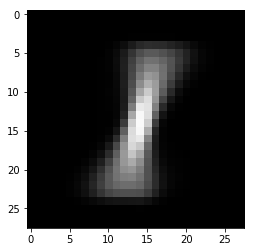

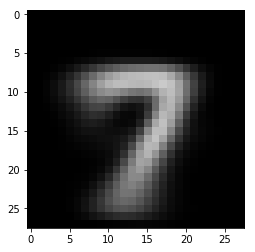

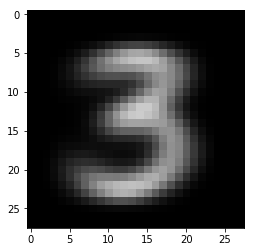

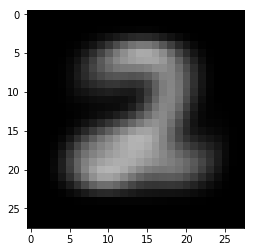

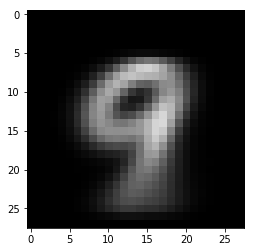

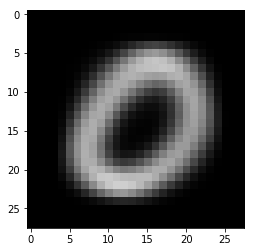

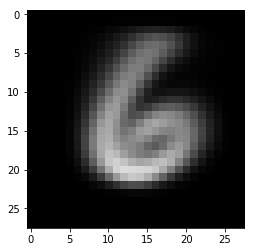

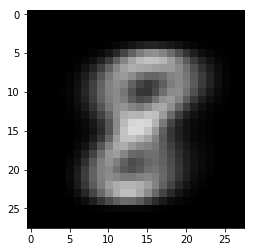

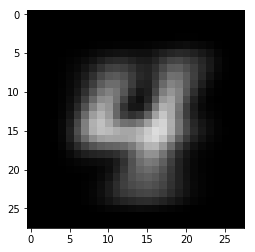

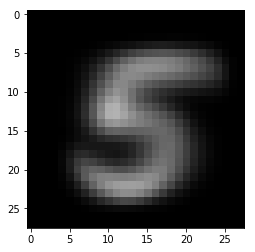

In [33]:
accuracy_norm_origin = accuracy('gaussian', False, is_ploting_images=True)

In [ ]:
accuracy_norm_origin = accuracy('gaussian', False)
accuracy_norm_stretched = accuracy('gaussian', True)
accuracy_bernoulli_origin = accuracy('bernoulli', False)
accuracy_bernoulli_streched = accuracy('bernoulli', True)

In [20]:
accuracy_norm_origin, accuracy_norm_stretched, accuracy_bernoulli_origin, accuracy_bernoulli_streched

((0.7765833333333333, 0.7824),
 (0.8267666666666666, 0.837),
 (0.8385333333333334, 0.8434),
 (0.8221666666666667, 0.8337))

## RandomForestClassifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
def rfc_accuracy(classifier, stretched):
    train_set = train_images
    test_set = test_images
    if(stretched):
        train_set = train_strech
        test_set = test_strech
    classifier.fit(train_set, train_labels)
    return classifier.score(train_set, train_labels), classifier.score(test_set, test_labels) 

In [23]:
classifier10_4 = RandomForestClassifier(n_estimators=10, max_depth=4, n_jobs=10)
classifier10_16 = RandomForestClassifier(n_estimators=10, max_depth=16, n_jobs=10)
classifier30_4 = RandomForestClassifier(n_estimators=30, max_depth=4, n_jobs=10)
classifier30_16 = RandomForestClassifier(n_estimators=30, max_depth=16, n_jobs=10)

In [24]:
acc_rfc1 = rfc_accuracy(classifier10_4, stretched = True)
acc_rfc2 = rfc_accuracy(classifier10_16, stretched = True)
acc_rfc3 = rfc_accuracy(classifier30_4, stretched = True)
acc_rfc4 = rfc_accuracy(classifier30_16, stretched = True)
acc_rfc5 = rfc_accuracy(classifier10_4, stretched = False)
acc_rfc6 = rfc_accuracy(classifier10_16, stretched = False)
acc_rfc7 = rfc_accuracy(classifier30_4, stretched = False)
acc_rfc8 = rfc_accuracy(classifier30_16, stretched = False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConv

In [25]:
acc_rfc1, acc_rfc2, acc_rfc3, acc_rfc4, acc_rfc5, acc_rfc6, acc_rfc7, acc_rfc8

((0.7032333333333334, 0.7164),
 (0.99465, 0.952),
 (0.7343333333333333, 0.7466),
 (0.9971333333333333, 0.9612),
 (0.7046833333333333, 0.7165),
 (0.9898166666666667, 0.9387),
 (0.7298166666666667, 0.7386),
 (0.9947666666666667, 0.9543))